In [ ]:
import pandas as pd

# Definiamo i nomi delle colonne
column_names = [
    'id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean',
    'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
    'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
    'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst',
    'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst',
    'fractal_dimension_worst'
]

# Caricamento del dataset
data = pd.read_csv('wdbc.data', header=None, names=column_names)

In [ ]:
from pgmpy.estimators import HillClimbSearch, K2Score
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import KBinsDiscretizer

# Separa le feature dal target e dall'ID
features = data.drop(columns=['id', 'diagnosis'])
target = data['diagnosis']

# Discretizza solo le colonne numeriche delle feature
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform', subsample=None)
features_disc = pd.DataFrame(discretizer.fit_transform(features), columns=features.columns, index=data.index).astype(int)

# Unisci le feature discretizzate con il target per l'apprendimento del modello
data_disc = pd.concat([features_disc, target], axis=1)

In [ ]:
# Apprendimento della struttura
#hc = HillClimbSearch(data_disc)
#scoring_method = K2Score(data_disc)
#best_model = hc.estimate(scoring_method=scoring_method)
#print("Archi appresi:", best_model.edges())
#
## Fit dei parametri
#bn = BayesianNetwork(best_model.edges())
#bn.fit(data_disc)
#
## Inferenza di esempio
#inference = VariableElimination(bn)
## Esempio di query con 'concavity_mean' discretizzato al valore più alto (2)
#query = inference.query(variables=['diagnosis'], evidence={'concavity_mean': 2})
#print(query)

In [ ]:
# Apprendimento della struttura
scoring_method = K2Score(data_disc)
hc = HillClimbSearch(data_disc)
best_model = hc.estimate(scoring_method=scoring_method, max_indegree=5, max_iter=int(1e4))
print("Archi appresi:", best_model.edges())

# Fit dei parametri
bn = BayesianNetwork(best_model.edges())
bn.fit(data_disc)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))

# Crea un grafo da networkx usando gli archi del modello appreso
G = nx.DiGraph(best_model.edges())

# Definisci i colori dei nodi: uno per 'diagnosis', un altro per gli altri
node_colors = ['red' if node == 'diagnosis' else 'skyblue' for node in G.nodes()]

# Disegna il grafo

# Aumentando 'k' si aumenta la distanza tra i nodi, e più iterazioni aiutano a raggiungere una configurazione stabile
# Aumentiamo k e la dimensione del font per una migliore visualizzazione
pos = nx.spring_layout(G, k=2.5, iterations=150)
nx.draw(G, pos, with_labels=True, node_size=5000, node_color=node_colors, font_size=25, font_weight='bold', arrows=True, arrowsize=23)
plt.title("Struttura della Rete Bayesiana Appresa", size=23)
plt.show()

In [ ]:
# Ottenere la Markov Blanket per il nodo 'diagnosis'
markov_blanket = bn.get_markov_blanket('diagnosis')

print(f"La Markov Blanket di 'diagnosis' è: {markov_blanket}")
print(f"\nNumero di features nella Markov Blanket: {len(markov_blanket)}")
print(f"\nSono state eliminate {32 - len(markov_blanket)} features.")
print("\nQueste sono le uniche variabili necessarie per predire la diagnosi secondo il modello appreso.")
print("Le altre variabili possono essere considerate ridondanti per questo scopo.")

features_ridotte = markov_blanket.copy()
if 'diagnosis' not in features_ridotte:
    features_ridotte.append('diagnosis')

data_ridotto = data_disc[features_ridotte]

In [ ]:
# Creiamo un sottografo con solo i nodi nella Markov Blanket
G_ridotto = G.subgraph(features_ridotte)

plt.figure(figsize=(20, 20))

# Definiamo i colori per il nuovo grafo
node_colors_ridotto = ['red' if node == 'diagnosis' else 'skyblue' for node in G_ridotto.nodes()]

# Disegniamo il grafo ridotto per una migliore visualizzazione delle relazioni dirette
pos_ridotto = nx.spring_layout(G_ridotto, k=3.5, iterations=150)
nx.draw(G_ridotto, pos_ridotto, with_labels=True, node_size=6000, node_color=node_colors_ridotto, font_size=20, font_weight='bold', arrows=True, arrowsize=20)
plt.title("Sottografo della Rete Bayesiana: (Markov Blanket)", size=25)
plt.show()

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Apprendimento della struttura per il modello ridotto basato sul sottografo
best_model_ridotto = bn.subgraph(features_ridotte)
print("Archi del modello ridotto:", best_model_ridotto.edges())

# Creazione e fit del modello ridotto
bn_ridotto = BayesianNetwork(best_model_ridotto.edges())
bn_ridotto.fit(data_ridotto)

# Preparazione dei dati per la valutazione
X_ridotto = data_ridotto.drop('diagnosis', axis=1)
le = LabelEncoder()
y_ridotto = pd.Series(le.fit_transform(data_ridotto['diagnosis']), index=data_ridotto.index, name='diagnosis')

# Divisione in set di training e test
X_train, X_test, y_train, y_test = train_test_split(X_ridotto, y_ridotto, test_size=0.3, random_state=42)

# Predizione sul test set
y_pred_labels = bn_ridotto.predict(X_test)

# Trasforma le etichette predette da stringhe a interi
y_pred = le.transform(y_pred_labels['diagnosis'])


# Valutazione del modello
accuracy = accuracy_score(y_test, y_pred)
report_str = classification_report(y_test, y_pred, target_names=le.classes_)
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)


print(f"Accuratezza del modello ridotto: {accuracy:.4f}\n")
print("Report del modello ridotto:\n", report_str)


Archi del modello ridotto: [('concavity_se', 'concavity_mean'), ('concavity_se', 'perimeter_worst'), ('concavity_se', 'concave_points_mean'), ('concavity_se', 'concave_points_worst'), ('concavity_se', 'area_mean'), ('concavity_se', 'fractal_dimension_se'), ('concavity_se', 'perimeter_mean'), ('concavity_se', 'texture_mean'), ('concavity_se', 'radius_worst'), ('radius_worst', 'perimeter_mean'), ('radius_worst', 'diagnosis'), ('area_mean', 'perimeter_worst'), ('area_mean', 'concave_points_mean'), ('area_mean', 'perimeter_mean'), ('perimeter_mean', 'concave_points_worst'), ('diagnosis', 'concave_points_worst'), ('diagnosis', 'texture_mean'), ('diagnosis', 'concave_points_mean'), ('concavity_mean', 'concave_points_mean'), ('fractal_dimension_se', 'concave_points_mean'), ('texture_se', 'texture_mean'), ('perimeter_se', 'concavity_mean'), ('perimeter_se', 'perimeter_worst'), ('perimeter_se', 'area_mean'), ('perimeter_se', 'fractal_dimension_se'), ('perimeter_se', 'perimeter_mean'), ('perimet

  0%|          | 0/59 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_94321_1af0ba08ac6a46edb41581860397f74f_8bd059e8cfa34c2890f3c6560ddea7d9 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_94321_af388622760b4f3cbf76cb8e11b4f88d_acbe305f17294153b961121e2ee4cbe7 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", l

Accuratezza del modello ridotto: 0.9649

Report del modello ridotto:
               precision    recall  f1-score   support

           B       0.96      0.99      0.97       108
           M       0.98      0.92      0.95        63

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171



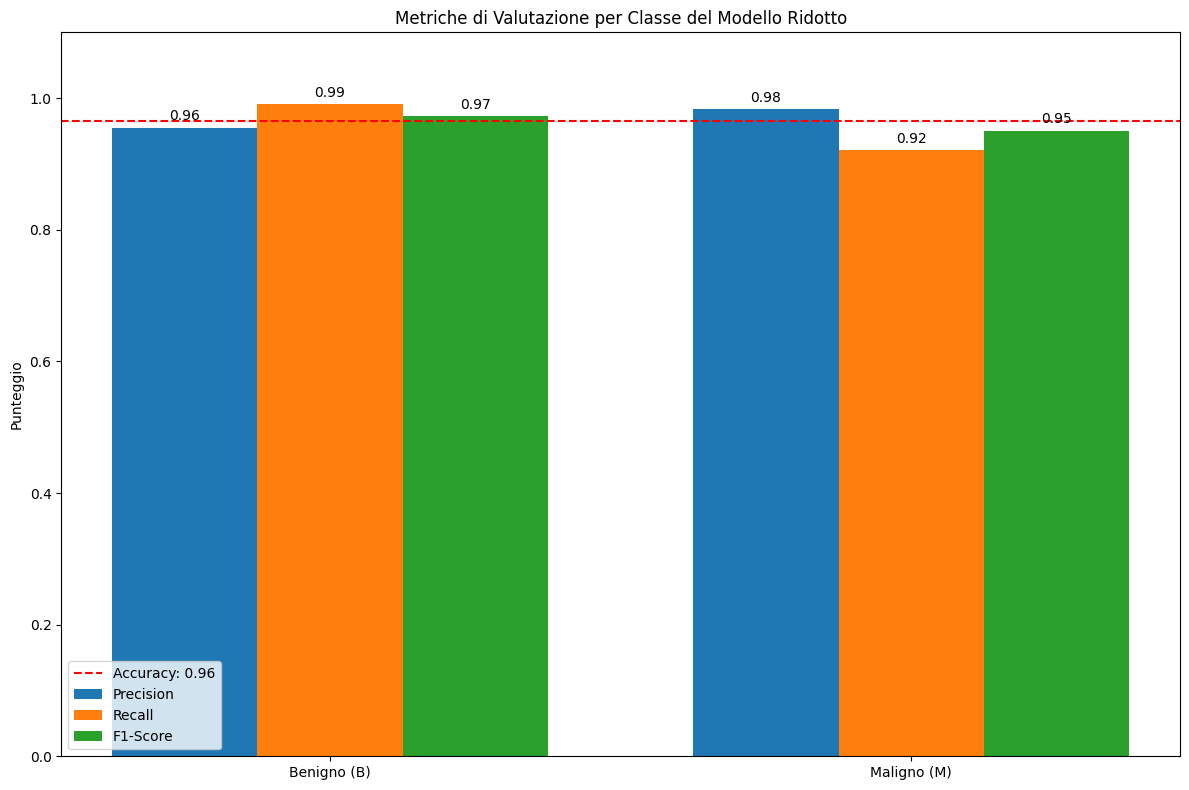

Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-94321-40yxbhw3 for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-94321-eu4qnz4v for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-94321-cu_xm00n for automatic clea

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Estrazione delle metriche dal report
labels = le.classes_
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1 = [report[label]['f1-score'] for label in labels]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-Score')

# Aggiungi etichette, titolo e legenda
ax.set_ylabel('Punteggio')
ax.set_title('Metriche di Valutazione per Classe del Modello Ridotto')
ax.set_xticks(x)
ax.set_xticklabels(['Benigno (B)', 'Maligno (M)'])

ax.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy: {accuracy:.2f}')
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

fig.tight_layout()
plt.ylim(0, 1.1)
plt.show()